In [2]:

import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import cv2
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(42)
np.random.seed(42)

print("✅ All libraries imported successfully!")

2025-12-06 13:19:51.872866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765027192.105673      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765027192.171794      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✅ All libraries imported successfully!


In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()
print("🧹 Cleared previous training session")

In [3]:

class Config:
    IMG_SIZE = (224, 224)
    BATCH_SIZE = 8
    EPOCHS = 4
    NUM_CLASSES = 4
    LEARNING_RATE = 0.0001
    DATA_PATH = '/kaggle/input/imagesoasis/Data' 

config = Config()

def check_dataset_structure():
    if os.path.exists(config.DATA_PATH):
        classes = os.listdir(config.DATA_PATH)
        print("📁 Dataset structure:")
        for class_name in classes:
            class_path = os.path.join(config.DATA_PATH, class_name)
            if os.path.isdir(class_path):
                num_images = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
                print(f"   {class_name}: {num_images} images")
    else:
        print("❌ Dataset path not found. Please check the path.")

check_dataset_structure()

📁 Dataset structure:
   Non Demented: 67222 images
   Very mild Dementia: 13725 images
   Moderate Dementia: 488 images
   Mild Dementia: 5002 images


In [4]:

def create_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,  
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.2,
        brightness_range=[0.8, 1.2],
        validation_split=0.2 
    )
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        config.DATA_PATH,
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )
    
    val_generator = train_datagen.flow_from_directory(
        config.DATA_PATH,
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )
    
    return train_generator, val_generator

print("🔄 Creating data generators...")
train_generator, val_generator = create_data_generators()

print(f"📊 Classes: {train_generator.class_indices}")
print(f"📈 Training samples: {train_generator.samples}")
print(f"📉 Validation samples: {val_generator.samples}")

🔄 Creating data generators...
Found 69151 images belonging to 4 classes.
Found 17286 images belonging to 4 classes.
📊 Classes: {'Mild Dementia': 0, 'Moderate Dementia': 1, 'Non Demented': 2, 'Very mild Dementia': 3}
📈 Training samples: 69151
📉 Validation samples: 17286


In [5]:

import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

tf.keras.backend.clear_session()

def create_enhanced_densenet():
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', 
              kernel_regularizer=tf.keras.regularizers.l2(0.001))(x) 
    x = Dropout(0.6)(x) 
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', 
              kernel_regularizer=tf.keras.regularizers.l2(0.001))(x) 
    x = Dropout(0.5)(x)  
    x = Dense(128, activation='relu')(x)
    predictions = Dense(config.NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    optimizer = Adam(learning_rate=config.LEARNING_RATE)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model

print("🧠 Creating ENHANCED DenseNet model with stronger regularization...")
model = create_enhanced_densenet()
print("✅ Enhanced model created successfully!")

🧠 Creating ENHANCED DenseNet model with stronger regularization...


I0000 00:00:1765006133.301871      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765006133.302514      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Enhanced model created successfully!


In [6]:

def create_callbacks():
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=1,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            'best_densenet_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    return callbacks

print("⏰ Callbacks configured:")
print("   - Early Stopping (patience: 7)")
print("   - Reduce LR on Plateau")
print("   - Model Checkpointing")

⏰ Callbacks configured:
   - Early Stopping (patience: 7)
   - Reduce LR on Plateau
   - Model Checkpointing


In [7]:
print("🎯 Starting model training WITH CLASS BALANCING...")

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train = train_generator.classes
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

print("📊 Applying class weights to address imbalance:")
class_names = list(train_generator.class_indices.keys())
for i, (class_name, weight) in enumerate(zip(class_names, class_weights)):
    samples = np.sum(y_train == i)
    print(f"   {class_name}: {samples} samples → weight: {weight:.2f}x")

callbacks = create_callbacks()

history = model.fit(
    train_generator,
    epochs=config.EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weight_dict,  
    verbose=1
)

print("✅ Training completed with class balancing!")

🎯 Starting model training WITH CLASS BALANCING...
📊 Applying class weights to address imbalance:
   Mild Dementia: 4002 samples → weight: 4.32x
   Moderate Dementia: 391 samples → weight: 44.21x
   Non Demented: 53778 samples → weight: 0.32x
   Very mild Dementia: 10980 samples → weight: 1.57x
Epoch 1/4


I0000 00:00:1765006160.248363     126 service.cc:148] XLA service 0x7cc0d00025c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765006160.249207     126 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765006160.249220     126 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765006163.060337     126 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/8644 ━━━━━━━━━━━━━━━━━━━━ 63:23:04 26s/step - accuracy: 0.2500 - loss: 2.3014 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1765006173.517055     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8644/8644 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.3494 - loss: 2.1138 - precision: 0.3930 - recall: 0.1010
Epoch 1: val_accuracy improved from -inf to 0.41230, saving model to best_densenet_model.h5


8644/8644 ━━━━━━━━━━━━━━━━━━━━ 1589s 181ms/step - accuracy: 0.3494 - loss: 2.1138 - precision: 0.3930 - recall: 0.1010 - val_accuracy: 0.4123 - val_loss: 1.7619 - val_precision: 0.6010 - val_recall: 0.1605 - learning_rate: 1.0000e-04
Epoch 2/4
8644/8644 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.4487 - loss: 1.6470 - precision: 0.6857 - recall: 0.2064
Epoch 2: val_accuracy improved from 0.41230 to 0.48345, saving model to best_densenet_model.h5


8644/8644 ━━━━━━━━━━━━━━━━━━━━ 1236s 143ms/step - accuracy: 0.4487 - loss: 1.6470 - precision: 0.6857 - recall: 0.2064 - val_accuracy: 0.4835 - val_loss: 1.4719 - val_precision: 0.6464 - val_recall: 0.3294 - learning_rate: 1.0000e-04
Epoch 3/4
8644/8644 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5139 - loss: 1.3614 - precision: 0.7315 - recall: 0.3273
Epoch 3: val_accuracy did not improve from 0.48345
8644/8644 ━━━━━━━━━━━━━━━━━━━━ 1235s 143ms/step - accuracy: 0.5139 - loss: 1.3614 - precision: 0.7315 - recall: 0.3273 - val_accuracy: 0.4729 - val_loss: 1.4109 - val_precision: 0.6564 - val_recall: 0.3022 - learning_rate: 1.0000e-04
Epoch 4/4
8644/8644 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5128 - loss: 1.2581 - precision: 0.7057 - recall: 0.3317
Epoch 4: val_accuracy did not improve from 0.48345
8644/8644 ━━━━━━━━━━━━━━━━━━━━ 1220s 141ms/step - accuracy: 0.5128 - loss: 1.2581 - precision: 0.7057 - recall: 0.3317 - val_accuracy: 0.4571 - val_loss: 1.4016 - val_precision: 

📈 Plotting training history...


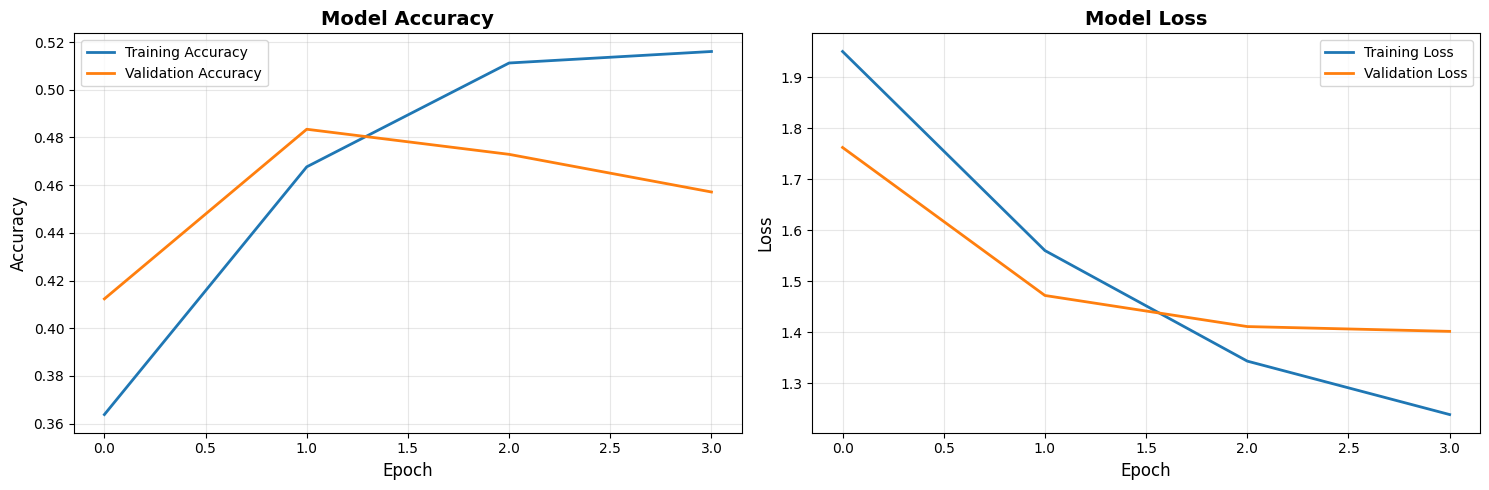

In [8]:
# Training history
def plot_training_history(history):
    plt.figure(figsize=(15, 5))
    
    # Accuracy plot 
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.title('Model Accuracy', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Model Loss', fontsize=14, fontweight='bold')
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("📈 Plotting training history...")
plot_training_history(history)

📊 Performing comprehensive evaluation...
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 263s 117ms/step
COMPREHENSIVE CLASSIFICATION REPORT
                    precision    recall  f1-score   support

     Mild Dementia       0.10      0.36      0.16      1000
 Moderate Dementia       0.02      0.86      0.03        97
      Non Demented       0.95      0.52      0.67     13444
Very mild Dementia       0.38      0.21      0.27      2745

          accuracy                           0.46     17286
         macro avg       0.36      0.49      0.28     17286
      weighted avg       0.80      0.46      0.57     17286



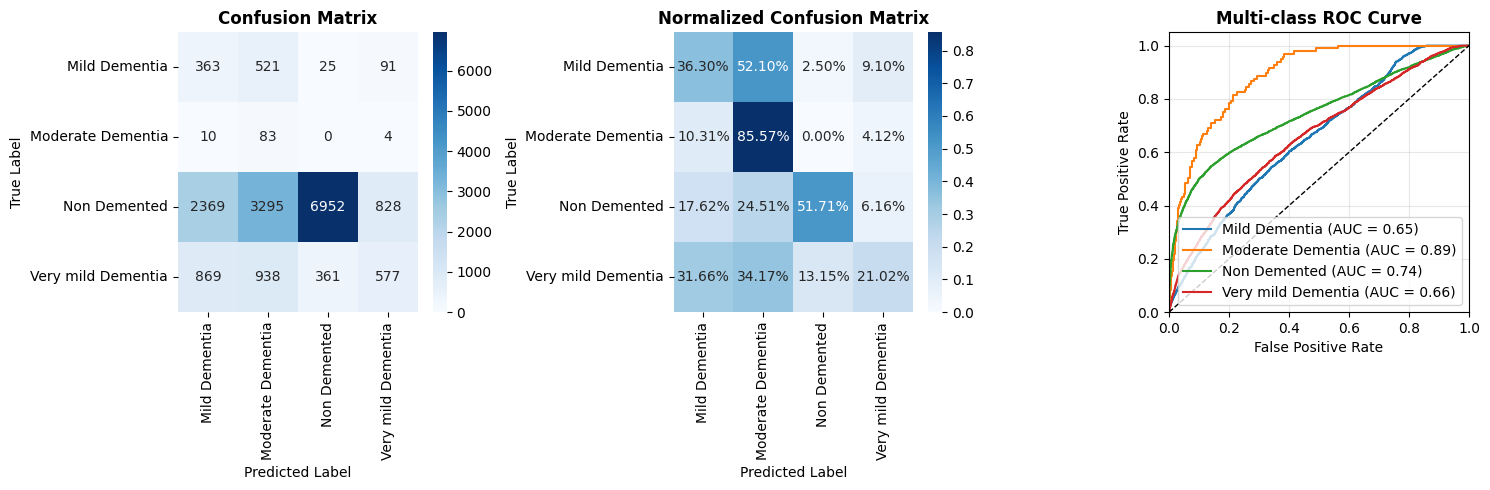


📊 Overall Accuracy: 0.4614

📈 Per-class Accuracy:
   Mild Dementia: 0.3630
   Moderate Dementia: 0.8557
   Non Demented: 0.5171
   Very mild Dementia: 0.2102


In [9]:
def comprehensive_evaluation(model, val_generator):
    
    val_generator.reset()
    y_true = val_generator.classes
    y_pred_proba = model.predict(val_generator, verbose=1)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    
    class_labels = list(val_generator.class_indices.keys())
    
    # 1. Classification Report
    print("=" * 60)
    print("COMPREHENSIVE CLASSIFICATION REPORT")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_labels))
    
    # 2. Confusion Matrix
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix', fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 3. Normalized Confusion Matrix
    plt.subplot(1, 3, 2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Normalized Confusion Matrix', fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 4. ROC Curve (One-vs-Rest for multi-class)
    plt.subplot(1, 3, 3)
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])
    
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(config.NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve', fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 5. Additional Metrics
    accuracy = np.mean(y_true == y_pred)
    print(f"\n📊 Overall Accuracy: {accuracy:.4f}")
    
    # Per-class accuracy
    class_accuracy = {}
    print("\n📈 Per-class Accuracy:")
    for i, label in enumerate(class_labels):
        class_mask = y_true == i
        if np.sum(class_mask) > 0:  # Avoid division by zero
            class_accuracy[label] = np.mean(y_pred[class_mask] == i)
            print(f"   {label}: {class_accuracy[label]:.4f}")
    
    return y_true, y_pred, y_pred_proba

print("📊 Performing comprehensive evaluation...")
y_true, y_pred, y_pred_proba = comprehensive_evaluation(model, val_generator)

👀 Visualizing sample predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


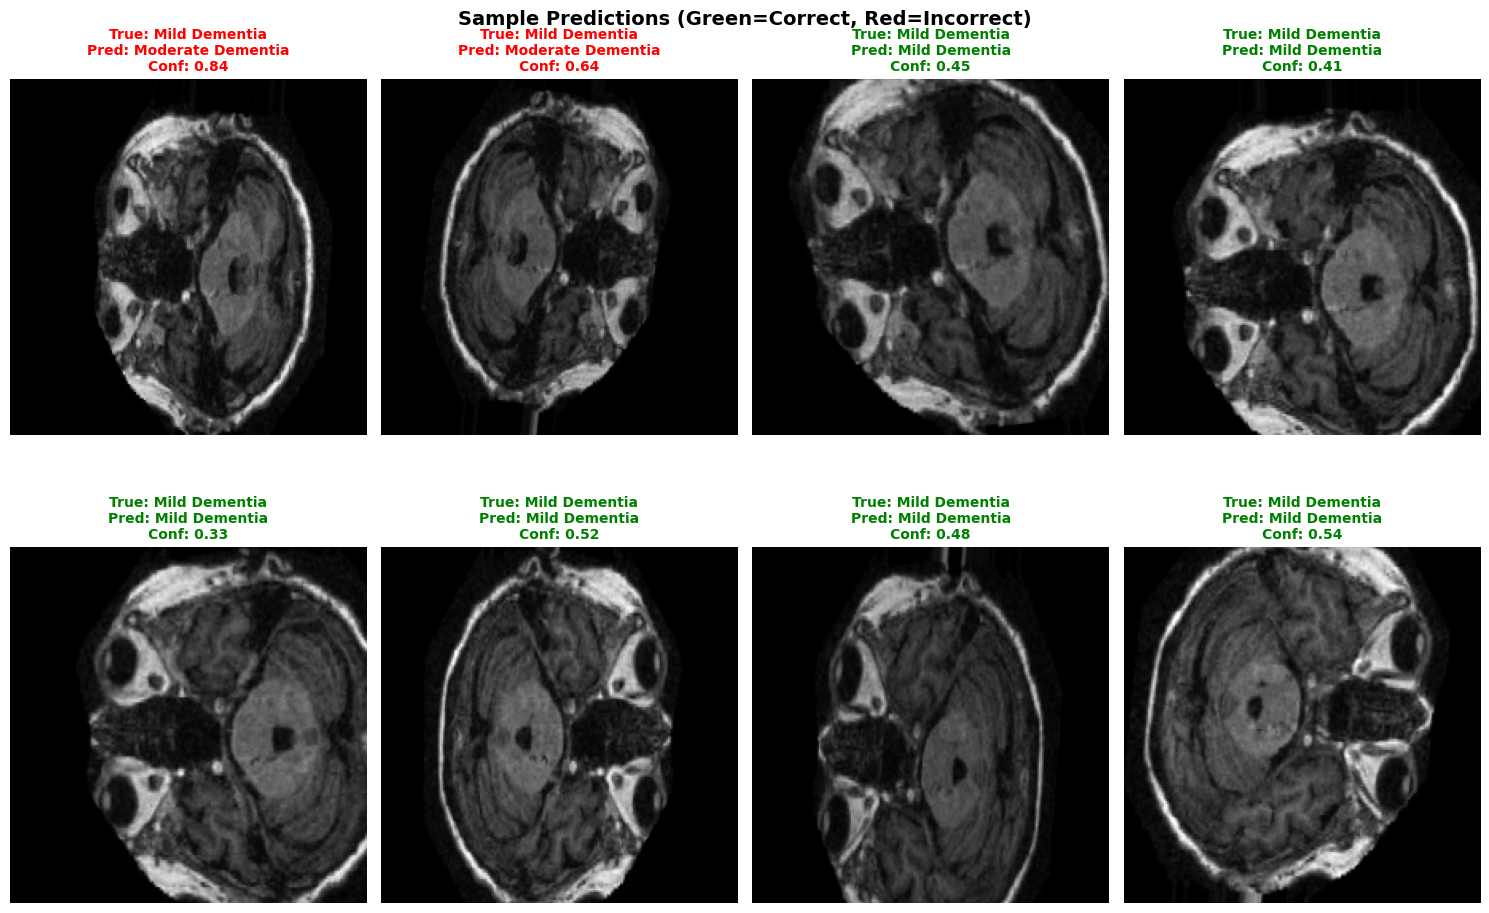

In [10]:

def visualize_predictions(model, val_generator, num_samples=8):
    val_generator.reset()
    x_batch, y_batch = next(val_generator)
    y_pred = model.predict(x_batch)
    
    class_labels = list(val_generator.class_indices.keys())
    
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(2, 4, i+1)
        plt.imshow(x_batch[i])
        true_label = class_labels[np.argmax(y_batch[i])]
        pred_label = class_labels[np.argmax(y_pred[i])]
        confidence = np.max(y_pred[i])
        
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}', 
                 color=color, fontsize=10, fontweight='bold')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=14, fontweight='bold')
    plt.show()

print("👀 Visualizing sample predictions...")
visualize_predictions(model, val_generator)

In [11]:

print("💾 Saving model...")
model.save('alzheimer_densenet_final.h5')

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print("\n" + "="*50)
print("🎯 FINAL TRAINING RESULTS")
print("="*50)
print(f"📈 Final Training Accuracy: {final_train_acc:.4f}")
print(f"📉 Final Validation Accuracy: {final_val_acc:.4f}")
print(f"📈 Final Training Loss: {final_train_loss:.4f}")
print(f"📉 Final Validation Loss: {final_val_loss:.4f}")

if len(history.history['accuracy']) > 1:
    initial_acc = history.history['accuracy'][0]
    improvement = final_train_acc - initial_acc
    print(f"📊 Accuracy Improvement: +{improvement:.4f}")

print("\n✅ Pipeline completed successfully!")
print("🚀 Model saved as 'alzheimer_densenet_final.h5'")

💾 Saving model...

🎯 FINAL TRAINING RESULTS
📈 Final Training Accuracy: 0.5161
📉 Final Validation Accuracy: 0.4571
📈 Final Training Loss: 1.2385
📉 Final Validation Loss: 1.4016
📊 Accuracy Improvement: +0.1523

✅ Pipeline completed successfully!
🚀 Model saved as 'alzheimer_densenet_final.h5'


In [12]:

def additional_analysis():
    print("🔍 Additional Analysis for Research Paper:")
    print("-" * 50)
    
    trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
    total_params = trainable_params + non_trainable_params
    
    print(f"📐 Model Parameters:")
    print(f"   Trainable: {trainable_params:,}")
    print(f"   Non-trainable: {non_trainable_params:,}")
    print(f"   Total: {total_params:,}")
    
    print(f"\n📊 Class Distribution:")
    for class_name, class_idx in train_generator.class_indices.items():
        count = np.sum(y_true == class_idx)
        print(f"   {class_name}: {count} samples")

additional_analysis()

🔍 Additional Analysis for Research Paper:
--------------------------------------------------
📐 Model Parameters:
   Trainable: 690,564
   Non-trainable: 7,038,528
   Total: 7,729,092

📊 Class Distribution:
   Mild Dementia: 1000 samples
   Moderate Dementia: 97 samples
   Non Demented: 13444 samples
   Very mild Dementia: 2745 samples


In [ ]:
print("🔬 Starting ablation experiments...")

def build_ablation_model(dropout1=0.6, dropout2=0.5):
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(dropout1)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(dropout2)(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(config.NUM_CLASSES, activation='softmax')(x)
    model_ab = Model(inputs=base_model.input, outputs=predictions)
    optimizer = Adam(learning_rate=config.LEARNING_RATE)
    model_ab.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    return model_ab

def create_no_aug_generators():
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    train_gen = datagen.flow_from_directory(
        config.DATA_PATH,
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )
    val_gen = datagen.flow_from_directory(
        config.DATA_PATH,
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )
    return train_gen, val_gen

def run_ablation_experiment(name,
                            use_class_weights=True,
                            use_augmentation=True,
                            dropout1=0.6,
                            dropout2=0.5,
                            epochs=2):
    tf.keras.backend.clear_session()
    if use_augmentation:
        train_gen = train_generator
        val_gen = val_generator
    else:
        train_gen, val_gen = create_no_aug_generators()
    model_ab = build_ablation_model(dropout1=dropout1, dropout2=dropout2)
    callbacks = create_callbacks()
    cw = class_weight_dict if use_class_weights else None
    history_ab = model_ab.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=callbacks,
        class_weight=cw,
        verbose=1
    )
    results = model_ab.evaluate(val_gen, verbose=0)
    metrics = dict(zip(model_ab.metrics_names, results))
    metrics["experiment"] = name
    metrics["use_class_weights"] = use_class_weights
    metrics["use_augmentation"] = use_augmentation
    metrics["dropout1"] = dropout1
    metrics["dropout2"] = dropout2
    metrics["epochs"] = epochs
    return metrics, history_ab

baseline_metrics, baseline_history = run_ablation_experiment(
    name="Baseline_full",
    use_class_weights=True,
    use_augmentation=True,
    dropout1=0.6,
    dropout2=0.5,
    epochs=4
)

no_cw_metrics, no_cw_history = run_ablation_experiment(
    name="No_class_weights",
    use_class_weights=False,
    use_augmentation=True,
    dropout1=0.6,
    dropout2=0.5,
    epochs=2
)

no_aug_metrics, no_aug_history = run_ablation_experiment(
    name="No_augmentation",
    use_class_weights=True,
    use_augmentation=False,
    dropout1=0.6,
    dropout2=0.5,
    epochs=2
)

low_do_metrics, low_do_history = run_ablation_experiment(
    name="Dropout_0_3",
    use_class_weights=True,
    use_augmentation=True,
    dropout1=0.3,
    dropout2=0.3,
    epochs=2
)

all_results = [
    baseline_metrics,
    no_cw_metrics,
    no_aug_metrics,
    low_do_metrics
]

ablation_results_df = pd.DataFrame(all_results)
print(ablation_results_df)


🔬 Starting ablation experiments...
Epoch 1/4
8644/8644 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.3385 - loss: 2.0770 - precision: 0.3833 - recall: 0.1039
Epoch 1: val_accuracy improved from -inf to 0.46066, saving model to best_densenet_model.h5


8644/8644 ━━━━━━━━━━━━━━━━━━━━ 1288s 146ms/step - accuracy: 0.3385 - loss: 2.0770 - precision: 0.3833 - recall: 0.1039 - val_accuracy: 0.4607 - val_loss: 1.6858 - val_precision: 0.6459 - val_recall: 0.1844 - learning_rate: 1.0000e-04
Epoch 2/4
8644/8644 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.4442 - loss: 1.6212 - precision: 0.6680 - recall: 0.1905
Epoch 2: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 2: val_accuracy did not improve from 0.46066
8644/8644 ━━━━━━━━━━━━━━━━━━━━ 1295s 150ms/step - accuracy: 0.4442 - loss: 1.6212 - precision: 0.6680 - recall: 0.1905 - val_accuracy: 0.3535 - val_loss: 1.7037 - val_precision: 0.4426 - val_recall: 0.1921 - learning_rate: 1.0000e-04
Epoch 3/4
8644/8644 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.4963 - loss: 1.3553 - precision: 0.7388 - recall: 0.3001
Epoch 3: val_accuracy did not improve from 0.46066
8644/8644 ━━━━━━━━━━━━━━━━━━━━ 1268s 147ms/step - accuracy: 0.4963 - loss: 1.3553 - precision: 0.738

8644/8644 ━━━━━━━━━━━━━━━━━━━━ 1359s 157ms/step - accuracy: 0.5272 - loss: 1.2446 - precision: 0.7149 - recall: 0.3609 - val_accuracy: 0.4802 - val_loss: 1.4018 - val_precision: 0.6095 - val_recall: 0.3625 - learning_rate: 2.0000e-05
Restoring model weights from the end of the best epoch: 4.
Epoch 1/2
8644/8644 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7632 - loss: 1.2941 - precision: 0.7781 - recall: 0.7369
Epoch 1: val_accuracy improved from -inf to 0.75032, saving model to best_densenet_model.h5


8644/8644 ━━━━━━━━━━━━━━━━━━━━ 1293s 147ms/step - accuracy: 0.7632 - loss: 1.2940 - precision: 0.7781 - recall: 0.7369 - val_accuracy: 0.7503 - val_loss: 0.9434 - val_precision: 0.9136 - val_recall: 0.5213 - learning_rate: 1.0000e-04
Epoch 2/2
8644/8644 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7776 - loss: 0.7943 - precision: 0.8023 - recall: 0.7458
Epoch 2: val_accuracy improved from 0.75032 to 0.76281, saving model to best_densenet_model.h5


8644/8644 ━━━━━━━━━━━━━━━━━━━━ 1257s 145ms/step - accuracy: 0.7776 - loss: 0.7943 - precision: 0.8023 - recall: 0.7458 - val_accuracy: 0.7628 - val_loss: 0.6973 - val_precision: 0.8887 - val_recall: 0.6005 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 2.
Found 69151 images belonging to 4 classes.
Found 17286 images belonging to 4 classes.
Epoch 1/2
8642/8644 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3626 - loss: 2.1922 - precision: 0.4272 - recall: 0.1346
Epoch 1: val_accuracy improved from -inf to 0.44840, saving model to best_densenet_model.h5


8644/8644 ━━━━━━━━━━━━━━━━━━━━ 334s 36ms/step - accuracy: 0.3626 - loss: 2.1921 - precision: 0.4272 - recall: 0.1346 - val_accuracy: 0.4484 - val_loss: 1.7154 - val_precision: 0.7727 - val_recall: 0.1574 - learning_rate: 1.0000e-04
Epoch 2/2
8643/8644 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4822 - loss: 1.5142 - precision: 0.6707 - recall: 0.2674
Epoch 2: val_accuracy did not improve from 0.44840
8644/8644 ━━━━━━━━━━━━━━━━━━━━ 285s 33ms/step - accuracy: 0.4822 - loss: 1.5142 - precision: 0.6707 - recall: 0.2674 - val_accuracy: 0.4283 - val_loss: 1.6106 - val_precision: 0.4975 - val_recall: 0.2968 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 2.
Epoch 1/2
8644/8644 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.4726 - loss: 1.9178 - precision: 0.6195 - recall: 0.2566
Epoch 1: val_accuracy improved from -inf to 0.49670, saving model to best_densenet_model.h5


8644/8644 ━━━━━━━━━━━━━━━━━━━━ 1269s 144ms/step - accuracy: 0.4726 - loss: 1.9177 - precision: 0.6195 - recall: 0.2566 - val_accuracy: 0.4967 - val_loss: 1.6621 - val_precision: 0.5986 - val_recall: 0.3762 - learning_rate: 1.0000e-04
Epoch 2/2
8644/8644 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5547 - loss: 1.4271 - precision: 0.6868 - recall: 0.4073